In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random
import shutil
from sklearn.model_selection import train_test_split

import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


## Data Analysis

In [ ]:
train_path = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")

letters = sorted(os.listdir(train_path))
print("Letters (classes):", letters)

Letters (classes): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


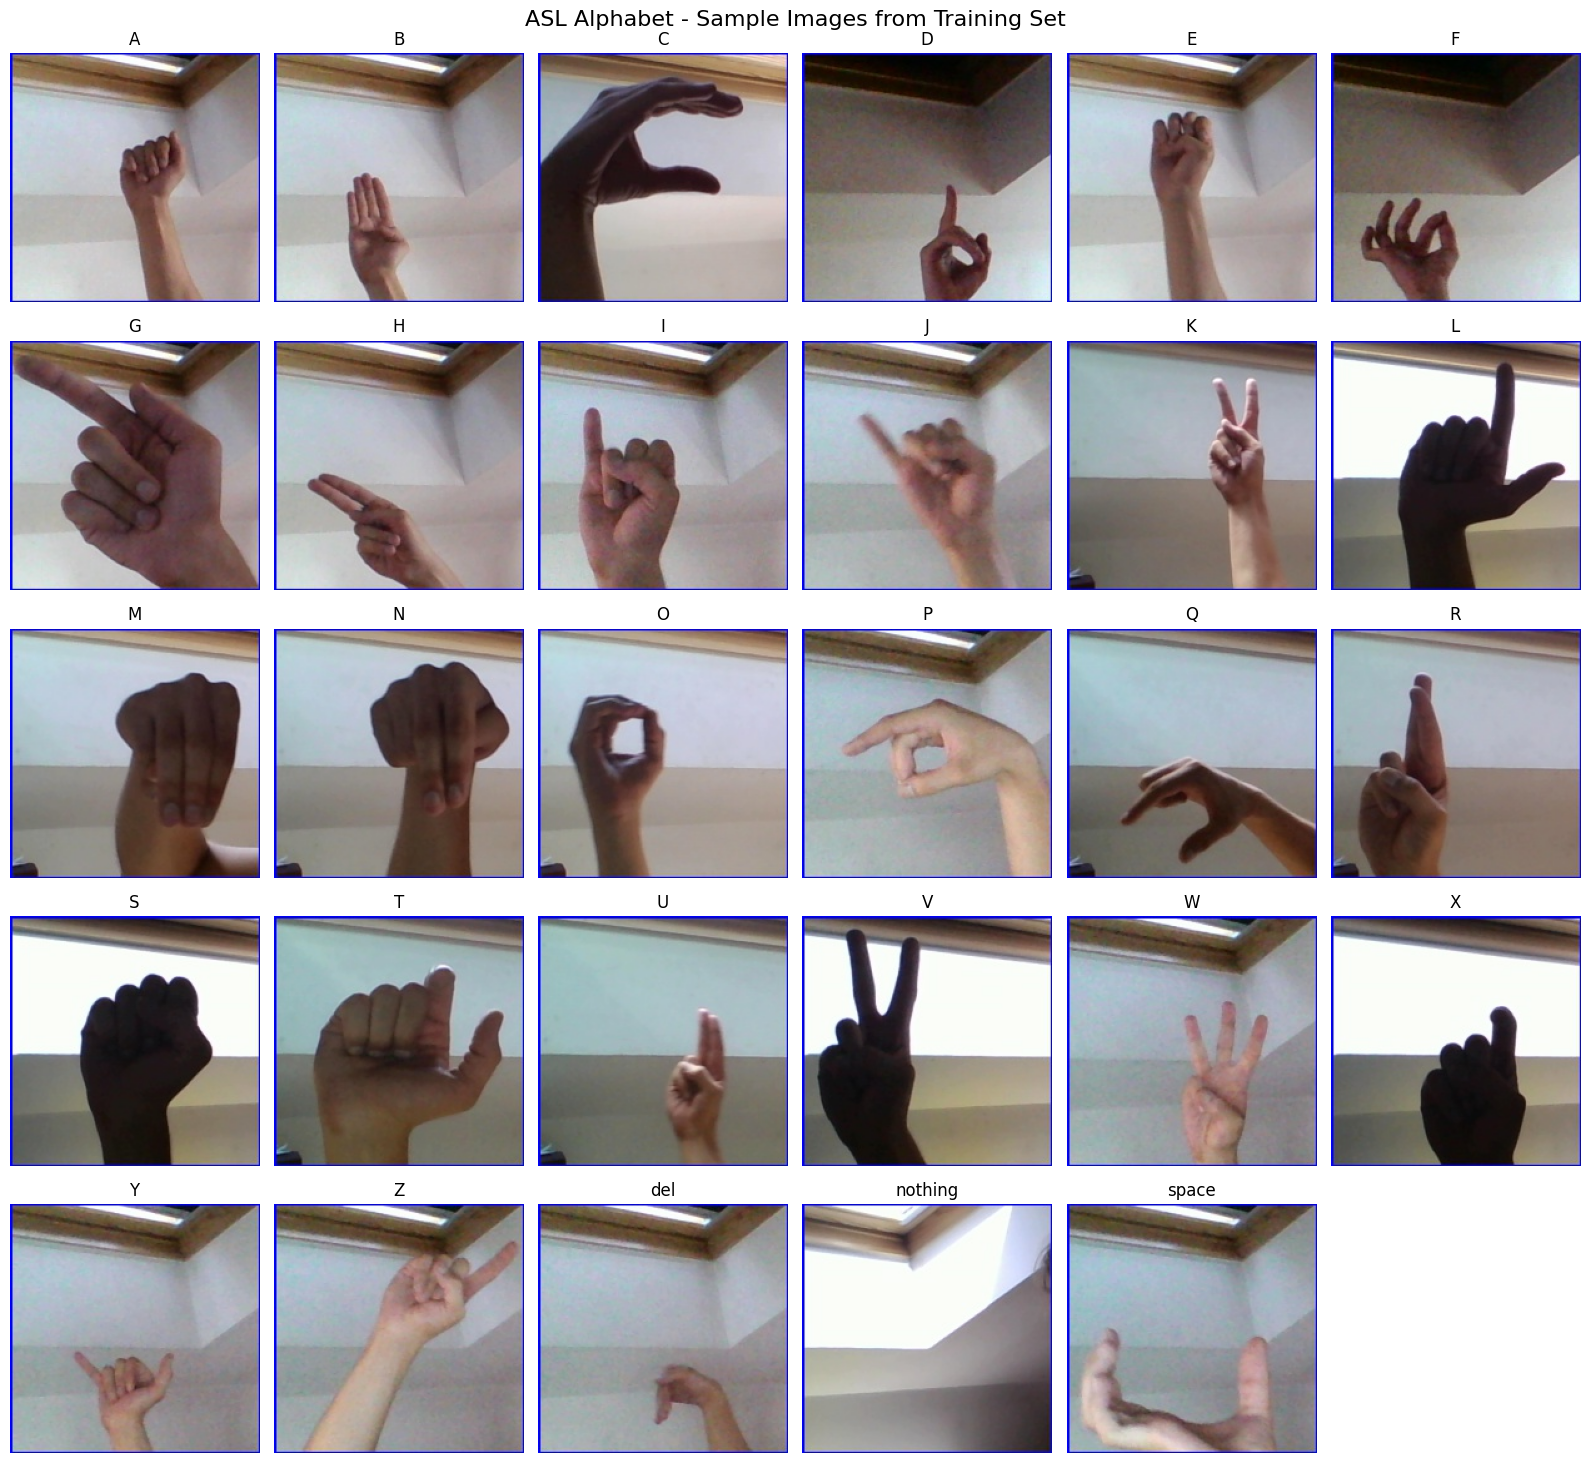

In [ ]:
# Visualize alphabet

fig, axes = plt.subplots(5, 6, figsize=(16, 15))
fig.suptitle("ASL Alphabet - Sample Images from Training Set", fontsize=16)

# Iterate over each letter folder and display a sample image
for idx, letter in enumerate(letters):
    folder_path = os.path.join(train_path, letter)

    # Let's choose a sample
    sample_image = random.choice(os.listdir(folder_path))         # randomised version
    #sample_image = os.listdir(folder_path)[0]
    image_path = os.path.join(folder_path, sample_image)

    # Read the image using OpenCV and convert from BGR to RGB for correct colors in matplotlib
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate grid position
    row = idx // 6
    col = idx % 6

    # Plot the image with the letter as the title
    axes[row, col].imshow(image)
    axes[row, col].set_title(letter)
    axes[row, col].axis("off")

# Hide extra subplot
axes[4, 5].axis("off")

plt.tight_layout()    #
plt.show()

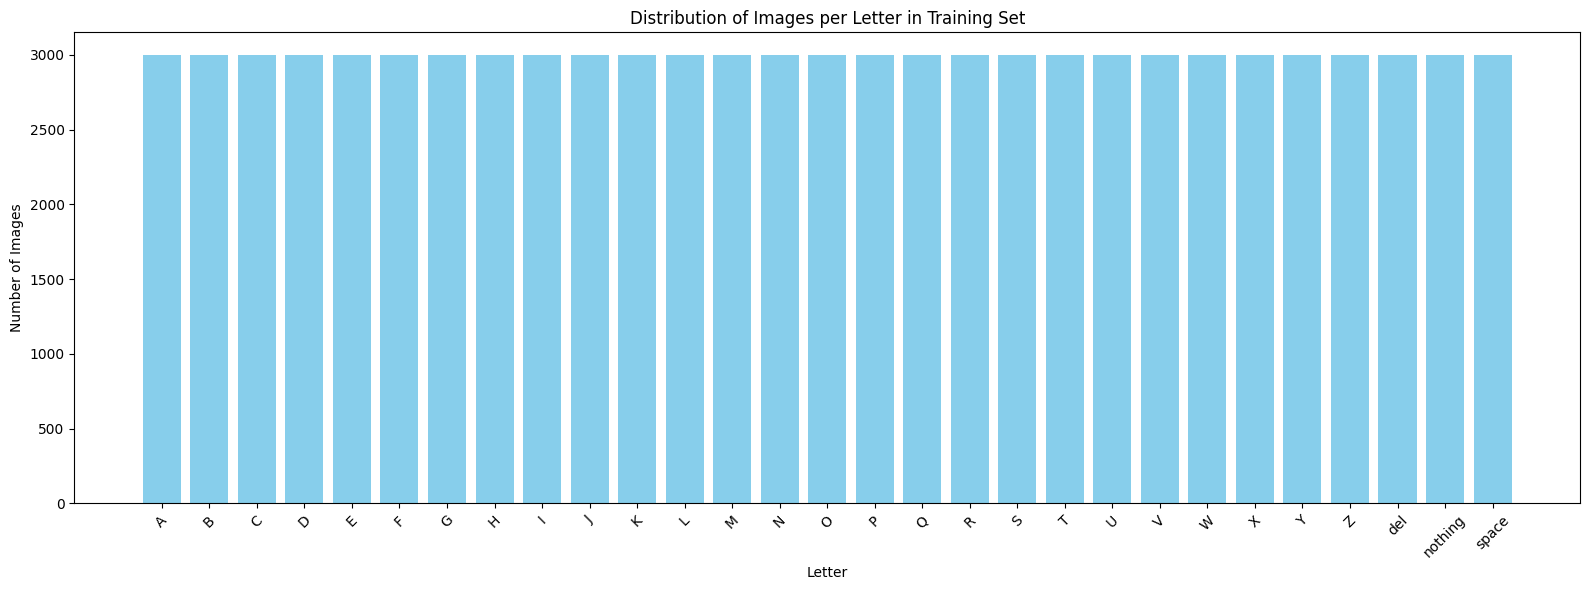

In [ ]:
# Count the samples in each letter folder

letter_counts = {}
for letter in letters:
    folder_path = os.path.join(train_path, letter)
    count = len(os.listdir(folder_path))
    letter_counts[letter] = count

# Plot a bar chart of the distribution
plt.figure(figsize=(16, 6))
plt.bar(letter_counts.keys(), letter_counts.values(), color='skyblue')
plt.xlabel("Letter")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Letter in Training Set")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## YOLO-Compatible Dataset Creation

In [ ]:
# YOLO CLASSIFICATION dataset folder structure

classification_yolo_path = "asl_classification_dataset"

# Define split ratios
train_ratio = 0.9
test_ratio = 0.1

# Create output directories
for split in ["train", "test"]:
    os.makedirs(os.path.join(classification_yolo_path, split), exist_ok=True)

# Process each class
for class_name in sorted(os.listdir(train_path)):
    class_path = os.path.join(train_path, class_name)

    # Collect all image files
    images = [img for img in os.listdir(class_path) if img.endswith(".jpg")]

    # Shuffle and split the letter folder
    train_files, test_files = train_test_split(images, train_size=train_ratio, test_size=test_ratio, stratify=None)

    # Create subdirectories
    for split, split_files in zip(["train", "test"],[train_files, test_files]):
        split_class_dir = os.path.join(classification_yolo_path, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy files
        for file in split_files:
            src = os.path.join(class_path, file)
            dest = os.path.join(split_class_dir, file)
            shutil.copy(src, dest)

In [ ]:
# Remove the NOTHING class

!rm -rf /kaggle/working/asl_classification_dataset/test/nothing
!rm -rf /kaggle/working/asl_classification_dataset/train/nothing

## Model Implementation

YOLO (You Only Look Once) is a deep learning model primarily designed for real-time object detection. However, recent versions are more versatile and support a wide range of computer vision tasks, including classification.
[YOLO11](https://docs.ultralytics.com/models/yolo11/) builds upon the foundational architecture of its predecessors, while introducing several key innovations. For our project, we chose the latest released **YOLO11s-classification** model due to its optimized architecture for real-time performance.


The **training settings** for YOLO models includes various hyperparameters and configurations used during the training process. These settings influence the model's performance, speed, and accuracy.


**Augmentation techniques** can also be tuned, they are essential for improving the robustness and performance of YOLO models by introducing variability into the training data, helping the model generalize better to unseen data.


In [ ]:
i!pip install ultralytics
!pip install ray[tune]==2.40.0      # Otherwise incongruence in _get_session method

from ultralytics import YOLO

#print("Ultralytics version:", ultralytics.__version__)
#print("Ray version", ray.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 23.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 26.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.42.0
    Uninstalling ray-2.42.0:
      Successfully uninstalled ray-2.42.0
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Empty runs folder if needed

#!rm -rf /kaggle/working/runs

In [ ]:
model = YOLO('yolo11s-cls.pt')

# TRAIN Settings
PATH = classification_yolo_path     # Path to the dataset configuration file .yaml
EPOCHS = 10                         # Total number of training epochs
IMG_SIZE = 200                      # Image size for training, our images are 200x200 but they'll be padded to 224x224 because it's the minimum
DEVICE = 0                          # Specifies the computational device for training, 0 = cuda
PATIENCE = 2                        # Number of epochs to wait without improvement in validation metrics before early stopping the training
BATCH = 32                          # Batch size
OPTIMIZER = 'auto'                  # Choice of optimizer for training (SGD, Adam, ...), 'auto' for automatic selection based on model configuration
SEED = 0                            # Sets the random seed for training, ensuring reproducibility
LR0 = 0.0001                        # Initial learning rate
LRF = 0.1                           # Final learning rate as a fraction of the initial rate
DROPOUT = 0.1                       # Dropout rate for regularization in classification tasks, preventing overfitting


# AUGMENTATION Settings
FLIPUD = 0.0                        # Probability of flipping the image upside (def 0.0)
FLIPLR = 0.0                        # Probability of flipping the image left to right, useful for learning symmetrical objects and increasing dataset diversity (def 0.5)
DEGREES = 5.0                       # Rotates the image randomly within +- the specified degree range (def 0.0) NOTE: high value mix del-c, i-j
SCALE = 0.5                         # Scales the image by a gain factor, simulating objects at different distances from the camera (def 0.5)
SHEAR = 20.0                        # Shears the image by a specified degree, mimicking the effect of objects being viewed from different angles (def 0.0)
PERSPECTIVE = 0.0005                # Applies a random perspective transformation to the image, enhancing the model's ability to understand objects in 3D space (def 0.0)
MOSAIC = 0.0                        # Combines four training images into one, simulating different scene compositions and object interactions (def 1.0)
ERASING = 0.0                       # Randomly erases a portion of the image during classification training, encouraging the model to focus on less obvious features.

results = model.train(
    data=PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    device=DEVICE,
    patience=PATIENCE,
    batch=BATCH,
    optimizer=OPTIMIZER,
    lr0=LR0,
    lrf=LRF,
    dropout=DROPOUT,
    seed=SEED,

    flipud = FLIPUD,
    fliplr = FLIPLR,
    degrees = DEGREES,
    scale = SCALE,
    shear = SHEAR,
    perspective = PERSPECTIVE,
    mosaic = MOSAIC,
    erasing = ERASING
)

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls.pt, data=asl_classification_dataset, epochs=10, time=None, patience=2, batch=32, imgsz=200, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning /kaggle/working/asl_classification_dataset/train... 75600 images, 0 corrupt: 100%|██████████| 75600/75600 [00:00<?, ?it/s]
val: Scanning /kaggle/working/asl_classification_dataset/test... 8400 images, 0 corrupt: 100%|██████████| 8400/8400 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10     0.992G      3.469         32        224:   0%|          | 6/2363 [00:01<05:53,  6.67it/s]

       1/10     0.992G      3.419         32        224:   0%|          | 9/2363 [00:01<04:41,  8.36it/s]
100%|██████████| 755k/755k [00:00<00:00, 24.4MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.98it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 13.06it/s]


                   all      0.999          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.83it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 13.01it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.96it/s]


                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.85it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.87it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 12.32it/s]

                   all          1          1
EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 0.503 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 11.1MB
Optimizer stripped from runs/classify/train/weights/best.pt, 11.1MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s-cls summary (fused): 112 layers, 5,469,996 parameters, 0 gradients, 12.0 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /kaggle/working/asl_classification_dataset/train... found 75600 images in 28 classes ✅ 
val: None...
test: /kaggle/working/asl_classification_dataset/test... found 8400 images in 28 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 132/132 [00:10<00:00, 13.00it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all          1          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
